Cumulative MSE: 16.913442586789998
Total Transmissions (Oracle): 127
Total Transmissions (Normal): 120


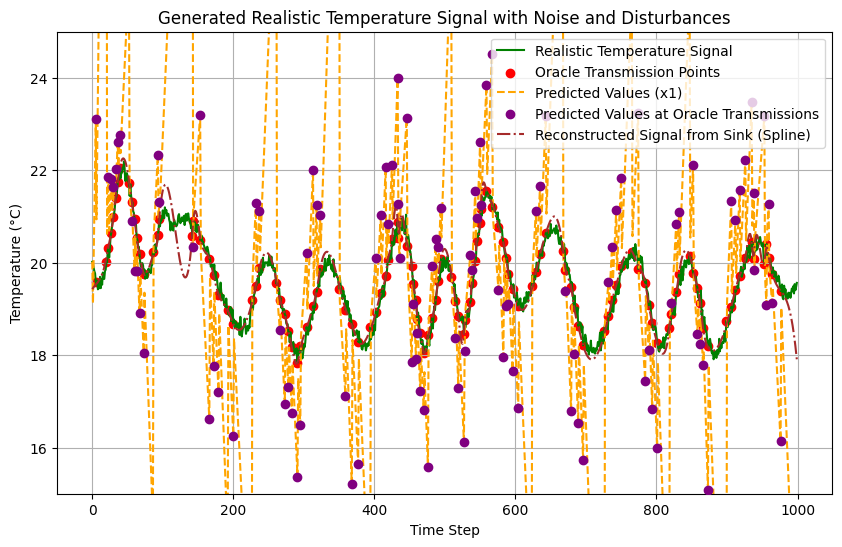

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 1
    cumulative_mse = 0
    oracle_transmission_count = 0
    voi_mse_list = []
    # Initialize the oracle's last transmitted value
    normal_transmission_count = 0
    oracle_last_transmitted_value = z_temp[0]
    predicted_values = [z_temp[0]]  # Initialize with the first value (for t=0)
    oracle_transmission_times = []  # To store the times when oracle transmits
    predicted_at_transmissions = []  # To store predicted values at oracle transmission points
    transmitted_values = []  # To store transmitted values (x1 and x2)
    last_transmission_time = 0

    x1, x2 = update_node_state_dewma(z_temp[0], last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)
    last_state_value = x1
    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        #last_state_value = measured_value
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)
        delta= t-last_transmission_time
        #predicted_value = x1
        # Calculate the predicted value using the rate of change and time elapsed
        predicted_value = last_state_value + last_rate_of_change * delta
        predicted_values.append(predicted_value)
        #predicted_values.append(x1)
        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(last_state_value - x1) > threshold:
            normal_transmission_count += 1
            #last_state_value = x1
            #last_rate_of_change = x2
            
            #last_transmission_time = t

        if np.abs(measured_value - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = measured_value  # Update the last transmitted value
            oracle_transmission_times.append(t)  # Store the time of oracle transmission
            predicted_at_transmissions.append(predicted_value)  # Store the predicted value at this transmission point
            transmitted_values.append((t, x1, x2))  # Store both x1 and x2 at the transmission points
            
            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(predicted_value, measured_value)
            cumulative_mse += mse
            oracle_transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis
            last_transmission_time = t
            last_state_value = measured_value
            last_rate_of_change = x2

        # Update the estimated state
        

    cumulative_mse = cumulative_mse / oracle_transmission_count

    return cumulative_mse, oracle_transmission_count,normal_transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, predicted_at_transmissions, transmitted_values


# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)

    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic


# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 200  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 0.1  # Amplitude of the noise
disturbance_probability = 0  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the push-based system
threshold = 0.3  # Threshold for VoI
beta_1 = 0.9  # dEWMA beta_1
beta_2 = 0.9  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, oracle_transmission_count, normal_transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, predicted_at_transmissions, transmitted_values = push_based_system_voi(T_realistic, total_time, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {oracle_transmission_count}")
print(f"Total Transmissions (Normal): {normal_transmission_count}")

# Plot the MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
"""plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Push-based System and Oracle at Transmission Points")
plt.legend()
plt.grid(True)
"""
# Plot the generated temperature signal with noise and disturbances
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Realistic Temperature Signal with Noise and Disturbances")
plt.ylim(15, 25)

# Highlight the points where the oracle transmits (VoI condition met)
plt.scatter(oracle_transmission_times, np.array(T_realistic)[oracle_transmission_times], color='red', label='Oracle Transmission Points')

# Plot the predicted values (based on x1 from dEWMA)
plt.plot(t, predicted_values, label="Predicted Values (x1)", color='orange', linestyle='--')

# Plot the predicted values at oracle transmission points (x1 at transmission times)
plt.scatter(oracle_transmission_times, predicted_at_transmissions, color='purple', label="Predicted Values at Oracle Transmissions", zorder=5)

# Reconstruct the temperature path using spline interpolation from transmitted data
transmitted_times, transmitted_x1_values, transmitted_x2_values = zip(*transmitted_values)

# Spline fitting: Use cubic spline interpolation to reconstruct the signal
spline_reconstruction = CubicSpline(transmitted_times, transmitted_x1_values, bc_type='natural')
reconstructed_signal = spline_reconstruction(t)

# Plot the reconstructed signal
plt.plot(t, reconstructed_signal, label="Reconstructed Signal from Sink (Spline)", color='brown', linestyle='-.')

plt.legend()
plt.grid(True)
plt.show()


Cumulative MSE: 0.00012992311845677122
Total Transmissions (Oracle): 96
Total Transmissions (Push): 154


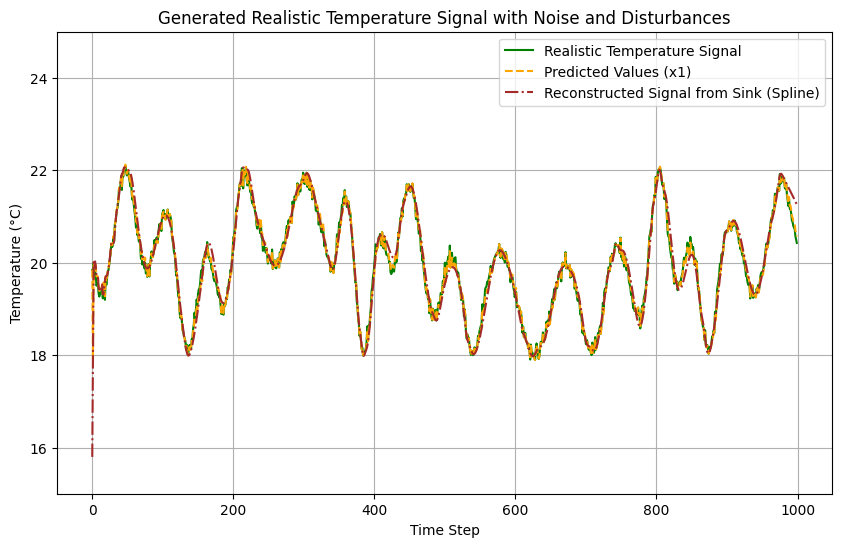

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0.5
    cumulative_mse = 0
    push_transmission_count = 0
    oracle_transmission_count = 0
    last_update_time = 0
    #voi_mse_list = []
    
    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    predicted_values = [z_temp[0]]  # Initialize with the first value (for t=0)
    oracle_transmission_times = []  # To store the times when oracle transmits
    push_transmission_times = []
    predicted_at_transmissions = []  # To store predicted values at oracle transmission points
    transmitted_values = []  # To store transmitted values (x1 and x2)

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)
        #mse = mse_between_estimate_and_true(x1, measured_value)
        # Calculate the predicted value using the rate of change and time elapsed
        #predicted_value = last_state_value + (last_rate_of_change * delta_t)
        predicted_values.append(x1)
        if np.abs( measured_value - oracle_last_transmitted_value) > threshold:
            oracle_last_transmitted_value = measured_value
            oracle_transmission_times.append(t)
            oracle_transmission_count += 1
            #oracle_last_transmitted_value = measured_value
            
    
        # Oracle decision (transmit only if VoI > threshold)
        #if np.abs( xmeasured_value - oracle_last_transmitted_value) > threshold:
        delta = t - last_update_time
        if np.abs(x2*delta) > threshold:
        #if np.abs( x1 - last_state_value ) > threshold:
              # Update the last transmitted value
             # Store the time of oracle transmission
            predicted_at_transmissions.append(x1)  # Store the predicted value at this transmission point
            transmitted_values.append((t, x1, x2))  # Store both x1 and x2 at the transmission points
            push_transmission_count += 1
            push_transmission_times.append(t) 
            last_update_time = t
        

        # Update the estimated state
            last_state_value = x1
            last_rate_of_change = x2
    mse = mse_between_estimate_and_true(x1, measured_value)
    cumulative_mse += mse
    cumulative_mse = cumulative_mse / push_transmission_count

    return cumulative_mse, push_transmission_count, oracle_transmission_count,predicted_values, oracle_transmission_times,push_transmission_times, predicted_at_transmissions, transmitted_values


# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)

    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic


# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 100  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 0.1  # Amplitude of the noise
disturbance_probability = 0  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the push-based system
threshold = 0.5  # Threshold for VoI
beta_1 = 0.9  # dEWMA beta_1
beta_2 = 0.1  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, push_transmission_count, oracle_transmission_count,predicted_values, oracle_transmission_times, push_transmission_times, predicted_at_transmissions, transmitted_values = push_based_system_voi(T_realistic, total_time, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {oracle_transmission_count}")
print(f"Total Transmissions (Push): {push_transmission_count}")


# Plot the generated temperature signal with noise and disturbances
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Realistic Temperature Signal with Noise and Disturbances")
plt.ylim(15, 25)


# Plot the predicted values (based on x1 from dEWMA)
plt.plot(t, predicted_values, label="Predicted Values (x1)", color='orange', linestyle='--')


# Reconstruct the temperature path using spline interpolation from transmitted data
transmitted_times, transmitted_x1_values, transmitted_x2_values = zip(*transmitted_values)

# Spline fitting: Use cubic spline interpolation to reconstruct the signal
spline_reconstruction = CubicSpline(transmitted_times, transmitted_x1_values, bc_type='natural')
reconstructed_signal = spline_reconstruction(t)

# Plot the reconstructed signal
plt.plot(t, reconstructed_signal, label="Reconstructed Signal from Sink (Spline)", color='brown', linestyle='-.')

plt.legend()
plt.grid(True)
plt.show()


# Pulling Section

Cumulative MSE: 0.12417059062025894
Total Transmissions (Oracle): 565
Total Transmissions (Pull): 426


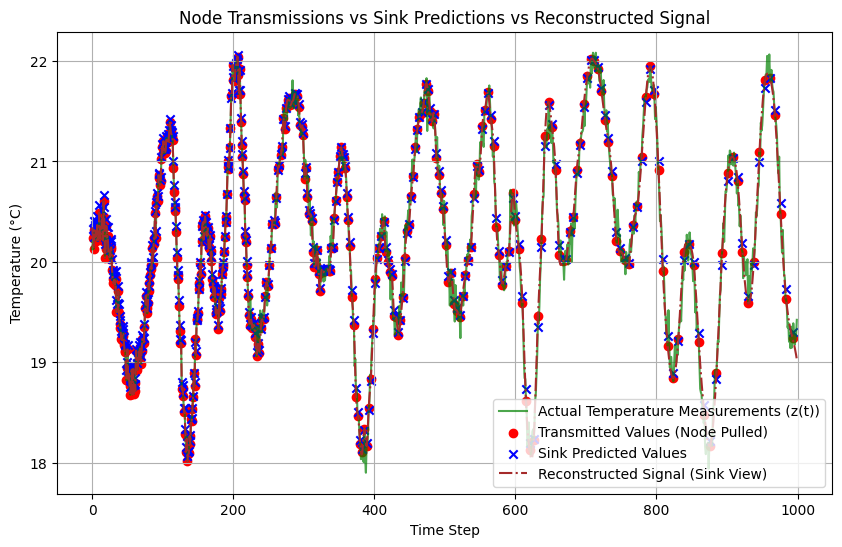

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update sink state using dEWMA
def update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_sink_value + last_sink_rate * delta_t)
    x2 = beta_2 * (x1 - last_sink_value) / delta_t + (1 - beta_2) * last_sink_rate
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the pull-based system (sink-side processing)
def pull_based_system_sink_dewma(z_temp, time_steps, threshold, beta_1, beta_2):
    transmission_times = []  # Time steps when the node transmits
    transmitted_values = []  # (Time, z(t))
    sink_predictions = []  # (Time, Predicted x1 at pull time)
    reconstructed_values = np.zeros(time_steps)  # Placeholder for reconstruction

    # **Initialize sink state with first measurement**
    last_sink_value = z_temp[0]  # First received measurement
    last_sink_rate = 1  # Initial rate of change is set to 1 (forces system to start updating)
    last_transmission_time = 0  # When last z(t) was received
    last_received_measurement = z_temp[0]
    oracle_last_transmitted_value = 0
    oracle_transmission_count = 0
    pull_transmission_count = 0
    cumulative_mse = 0

    for t in range(1, time_steps):
        delta_t = t - last_transmission_time  # Time since last transmission

        # **Sink Predicts Node's State using last received measurement and last sink rate**
        #sink_predicted_value = last_received_measurement + last_sink_rate * delta_t  
        measured_value = z_temp[t]
        #x1, x2 = update_sink_state_dewma(sink_predicted_value, last_sink_value, last_sink_rate, 1, beta_1, beta_2)
        #sink_predicted_value = x1 + x2 * delta_t
        #x2 = last_sink_rate
        if np.abs( measured_value - oracle_last_transmitted_value) > threshold:
            oracle_last_transmitted_value = measured_value
            oracle_transmission_times.append(t)
            oracle_transmission_count += 1

            
        # **Threshold Check**: Pull the node if the predicted change exceeds the threshold
        if (abs(last_sink_rate) * delta_t > threshold) or  min_rate_of_change * delta_t > threshold:
            # The sink pulls the node and receives a new measurement z(t)
            measured_value = z_temp[t]

            # **Sink updates itself using dEWMA**
            x1, x2 = update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2)

            # Store transmission times and values
            transmission_times.append(t)
            transmitted_values.append((t, measured_value))
            pull_transmission_count += 1

            # Store sink's predicted value at the time of pull
            #sink_predictions.append((t, sink_predicted_value))
            sink_predictions.append((t, x1))
            # Capture the push-based system's estimated value at this oracle transmission point
            #mse = mse_between_estimate_and_true(x1, measured_value)
            #cumulative_mse += mse

            # Update the last received values
            last_received_measurement = measured_value
            last_sink_value = x1
            last_sink_rate = x2
            last_transmission_time = t  # Update transmission time

        # **Reconstruct Signal**
        predicted = last_sink_value + last_sink_rate * delta_t
        reconstructed_values[t] = last_sink_value + last_sink_rate * delta_t
        mse = mse_between_estimate_and_true(predicted, measured_value)
        cumulative_mse += mse
    cumulative_mse = cumulative_mse / time_steps

    return cumulative_mse, pull_transmission_count , oracle_transmission_count, transmission_times, transmitted_values, sink_predictions, reconstructed_values

# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])
    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic

# Simulation Parameters
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1 
disturbance_probability = 0 
 

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# System Parameters
threshold = 0.1 
beta_1 = 0.9
beta_2 = 0.01
min_rate_of_change = 0.000
# Run the pull-based system simulation (sink-side processing)
cumulative_mse, pull_transmission_count , oracle_transmission_count,transmission_times, transmitted_values, sink_predictions, reconstructed_values = pull_based_system_sink_dewma(
    T_realistic, total_time, threshold, beta_1, beta_2
)

# Extract values for plotting
if transmitted_values:
    transmit_times, transmit_values = zip(*transmitted_values)
else:
    transmit_times, transmit_values = [], []

if sink_predictions:
    sink_pred_times, sink_pred_values = zip(*sink_predictions)
else:
    sink_pred_times, sink_pred_values = [], []

# **Check if enough points exist for a spline fit**
if len(transmit_times) > 1:
    spline = CubicSpline(transmit_times, transmit_values, bc_type='natural')
    smooth_reconstructed_values = spline(t)
else:
    smooth_reconstructed_values = np.interp(t, transmit_times, transmit_values) if transmit_times else np.zeros_like(t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {oracle_transmission_count}")
print(f"Total Transmissions (Pull): {pull_transmission_count}")

# **Plot the Results**
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Actual Temperature Measurements (z(t))", color='green', linestyle='-', alpha=0.7)

# Highlight transmitted values
plt.scatter(transmit_times, transmit_values, color='red', label="Transmitted Values (Node Pulled)")

# Highlight sink predictions at pull times
plt.scatter(sink_pred_times, sink_pred_values, color='blue', marker='x', label="Sink Predicted Values")

# Plot reconstructed values
plt.plot(t, smooth_reconstructed_values, label="Reconstructed Signal (Sink View)", color='brown', linestyle='-.')

plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Node Transmissions vs Sink Predictions vs Reconstructed Signal")
plt.legend()
plt.grid(True)
plt.show()


# Varying number of pulled nodes